In [1]:
import pandas as pd
import pickle

from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from collections import Counter

import helper as helper

In [2]:
disease_slim_term = []
with open('./data/drug_info/DO_slim.txt', 'r') as f:
    for line in f:
        tokens = line.split('\t')
        disease_slim_term.append(tokens[0])

In [3]:
drug_term2name = helper.term2name('./data/gmt/drugbank.2301.gmt')
omim_term2name = helper.term2name('./data/gmt/omim.20231030.gmt')

In [4]:
result = pd.read_csv('./results/drug_disease/drug_disease_fixed_seed.csv', index_col=0)

In [5]:
with open('./data/drug_info/drug_bank_atc.pickle', 'rb') as handle:
    drug2atc = pickle.load(handle)
    
with open('./data/drug_info/atc_name.pickle', 'rb') as handle:
    atc2name = pickle.load(handle)

In [6]:
atcs_type = []
atcs2term_disctinct = defaultdict(set)
for x in list(result.index):
    codes = [y[:1] for y in drug2atc[x]]
    if len(codes)>0:
        code_counter = Counter(codes)
        sorted_codes = sorted(code_counter, key=lambda y: code_counter[y])
        atcs_type.append(sorted_codes[-1])
        atcs2term_disctinct[sorted_codes[-1]].add(x)
    else:
        atcs_type.append('')

In [7]:
atcs2terms = defaultdict(set)
atcs_type_multi = []
for x in list(result.index):
    codes = [y[:1] for y in drug2atc[x]]
    atcs_type_multi.append(set(codes))
    for y in codes:
        atcs2terms[y].add(x)

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
pca_embedding = pca.fit_transform(result.values)

In [9]:
colormap = {'L': '#e31a1c', 'B': '#1f78b4', '': '#808080', 'A': '#b2df8a', 
            'S': '#33a02c', 'V': '#808080', 'D': '#fb9a99', 'C': '#a6cee3',
            'N': '#33a02c', 'R': '#fdbf6f', 'M': '#6a3d9a', 'G': '#b15928',
            'J': '#cab2d6', 'H': '#808080', 'P': '#808080'}

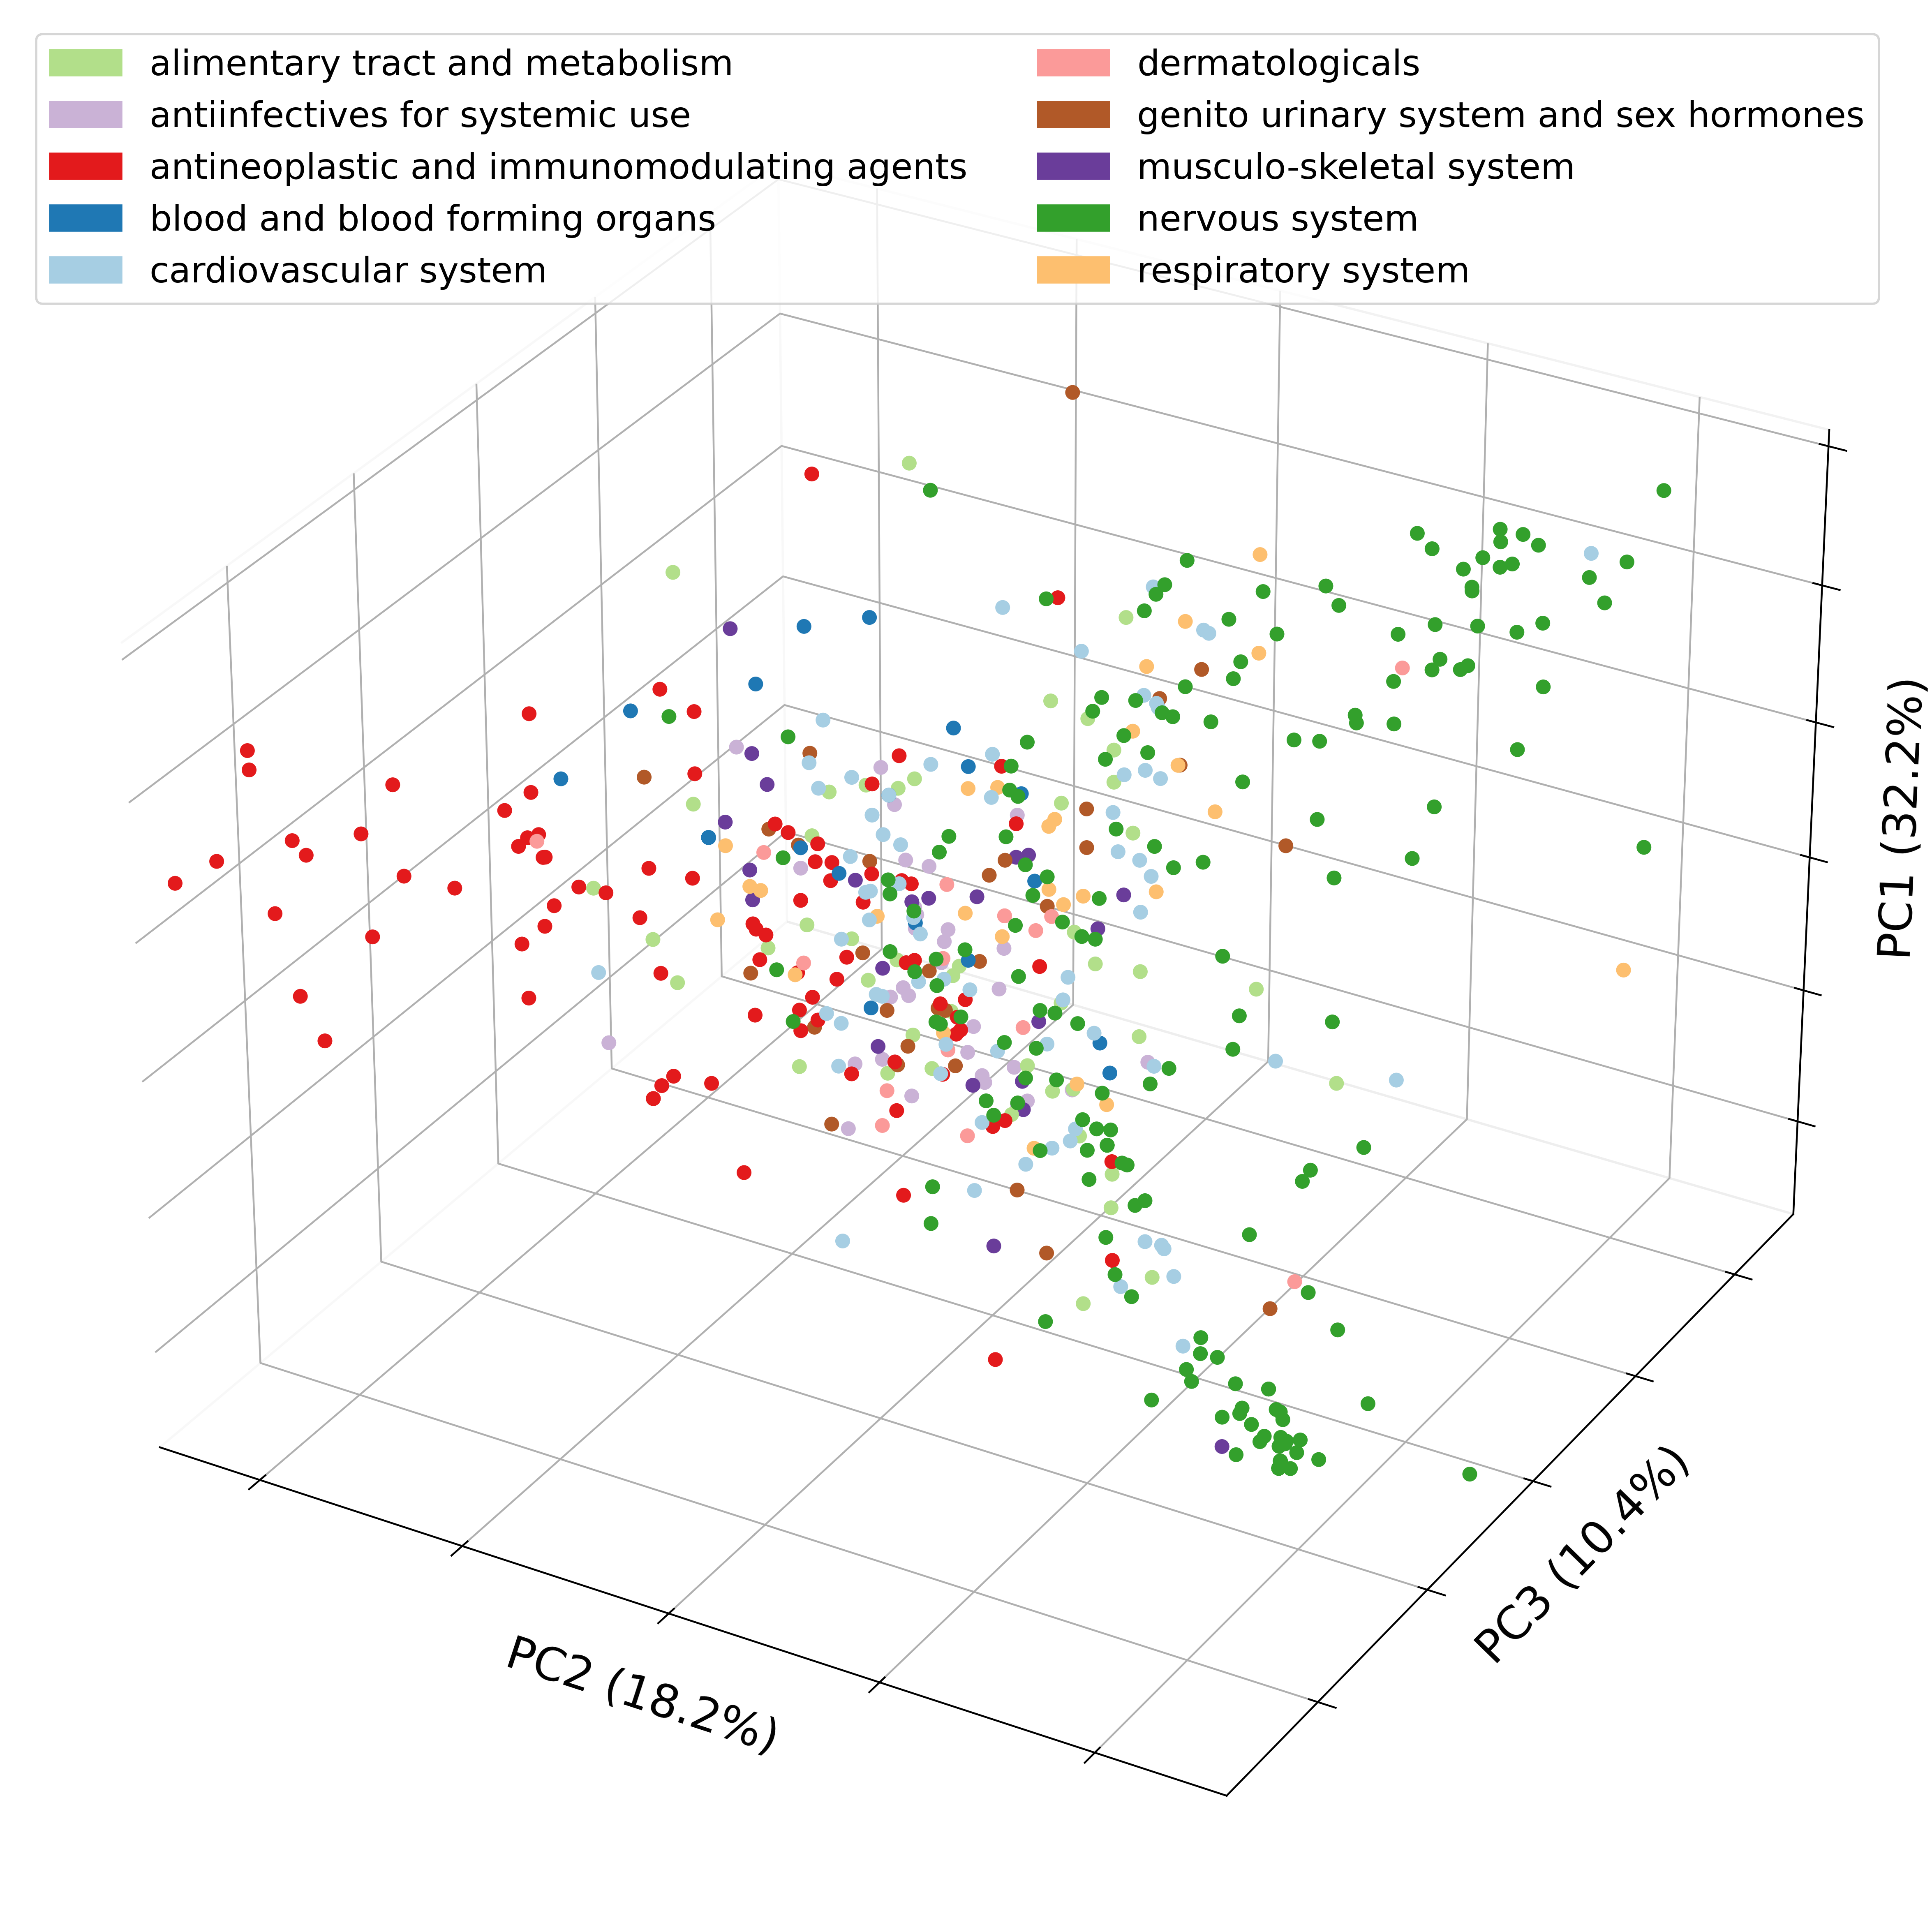

In [10]:
fig = plt.figure(figsize=(15,15), dpi=400) 
ax = fig.add_subplot(projection='3d')
colors = [colormap[x] for x in atcs_type]
used_indices = []
selected_atc_codes = ['B', 'S', 'V', 'D', 'R', 'M', 'G', 'J', 'H', 'P', 'A', 'C' ,'N','L']
colored_atc = []
for x in colormap.keys():
    if x=='':
        continue
    terms = atcs2term_disctinct[x]
    if len(terms)<=11:
        continue
    colored_atc.append(x)
    indices = [list(result.index).index(y) for y in terms]
    used_indices+=indices
    ax.scatter(pca_embedding[:,1][indices], 
               pca_embedding[:,2][indices],
               pca_embedding[:,0][indices],
                s=30, c=colormap[x], alpha=1)

ax.set_xlim(-24, 25)
ax.set_ylim(-27, 25)
ax.set_zlim(-26, 30)

ax.set_xlabel('PC2 (18.2%)', fontsize=20)
ax.set_ylabel('PC3 (10.4%)', fontsize=20)
ax.set_zlabel('PC1 (32.2%)', fontsize=20)

# ax.view_init(elev=20., azim=-35, roll=0)
for tick in ax.xaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
    tick.tick2line.set_visible(False)
    tick.label1.set_visible(False)
    tick.label2.set_visible(False)
    
for tick in ax.yaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
    tick.tick2line.set_visible(False)
    tick.label1.set_visible(False)
    tick.label2.set_visible(False)
    
for tick in ax.zaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
    tick.tick2line.set_visible(False)
    tick.label1.set_visible(False)
    tick.label2.set_visible(False)
    
patches = [mpatches.Patch(color=colormap[x], label=atc2name[x].lower()) 
           for x in sorted(colored_atc, key=lambda x: atc2name[x])]
plt.legend(handles = patches, ncol=2, prop={'size': 15.5},
           bbox_to_anchor=(0.99, 1))
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

In [12]:
omim_slim_terms = list(set(disease_slim_term).intersection(result.columns))

ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS


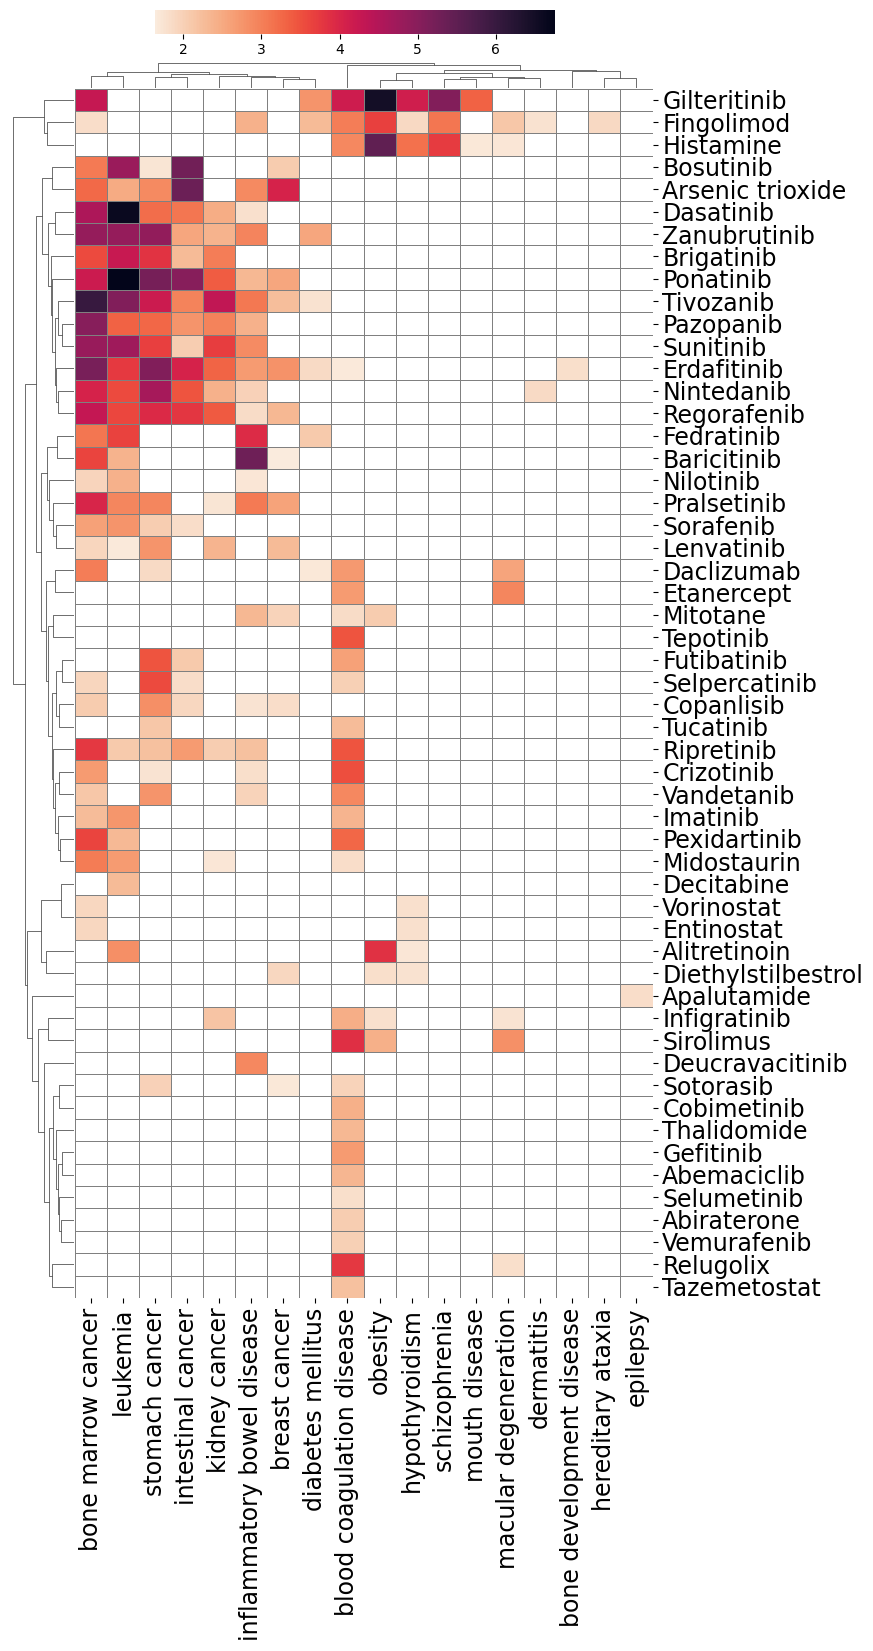

BLOOD AND BLOOD FORMING ORGANS


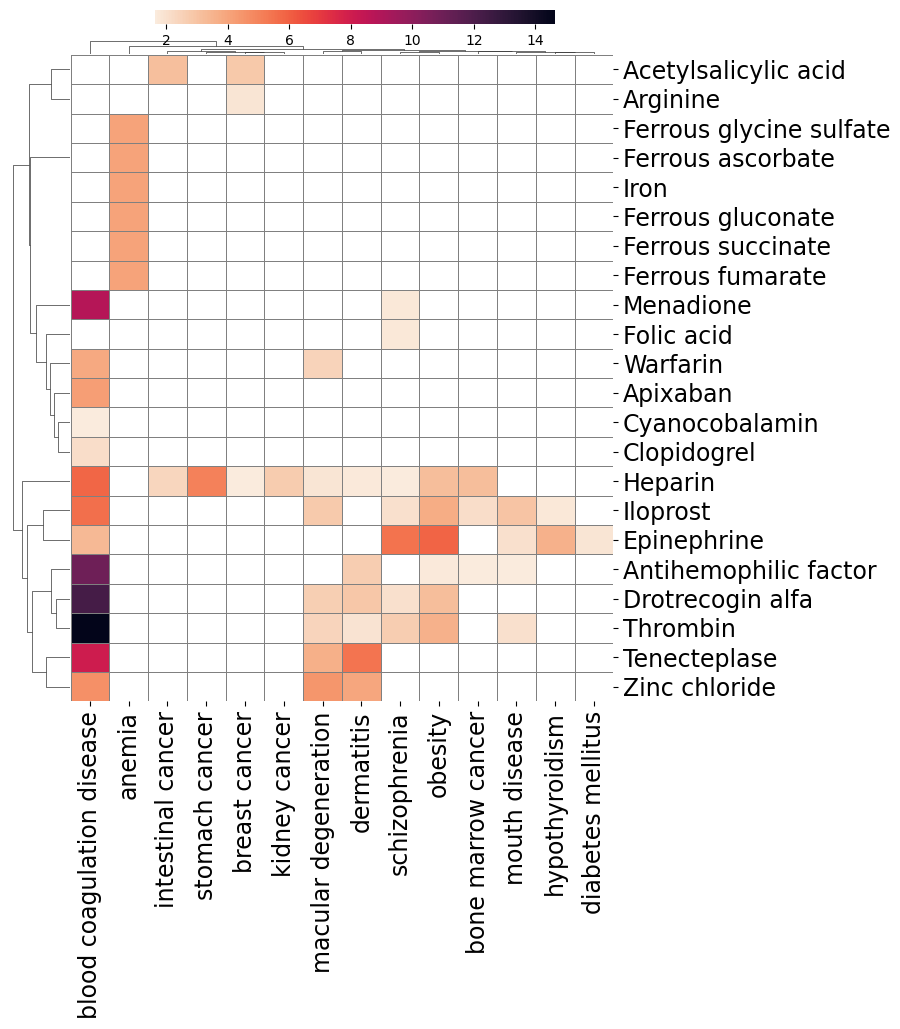

ALIMENTARY TRACT AND METABOLISM


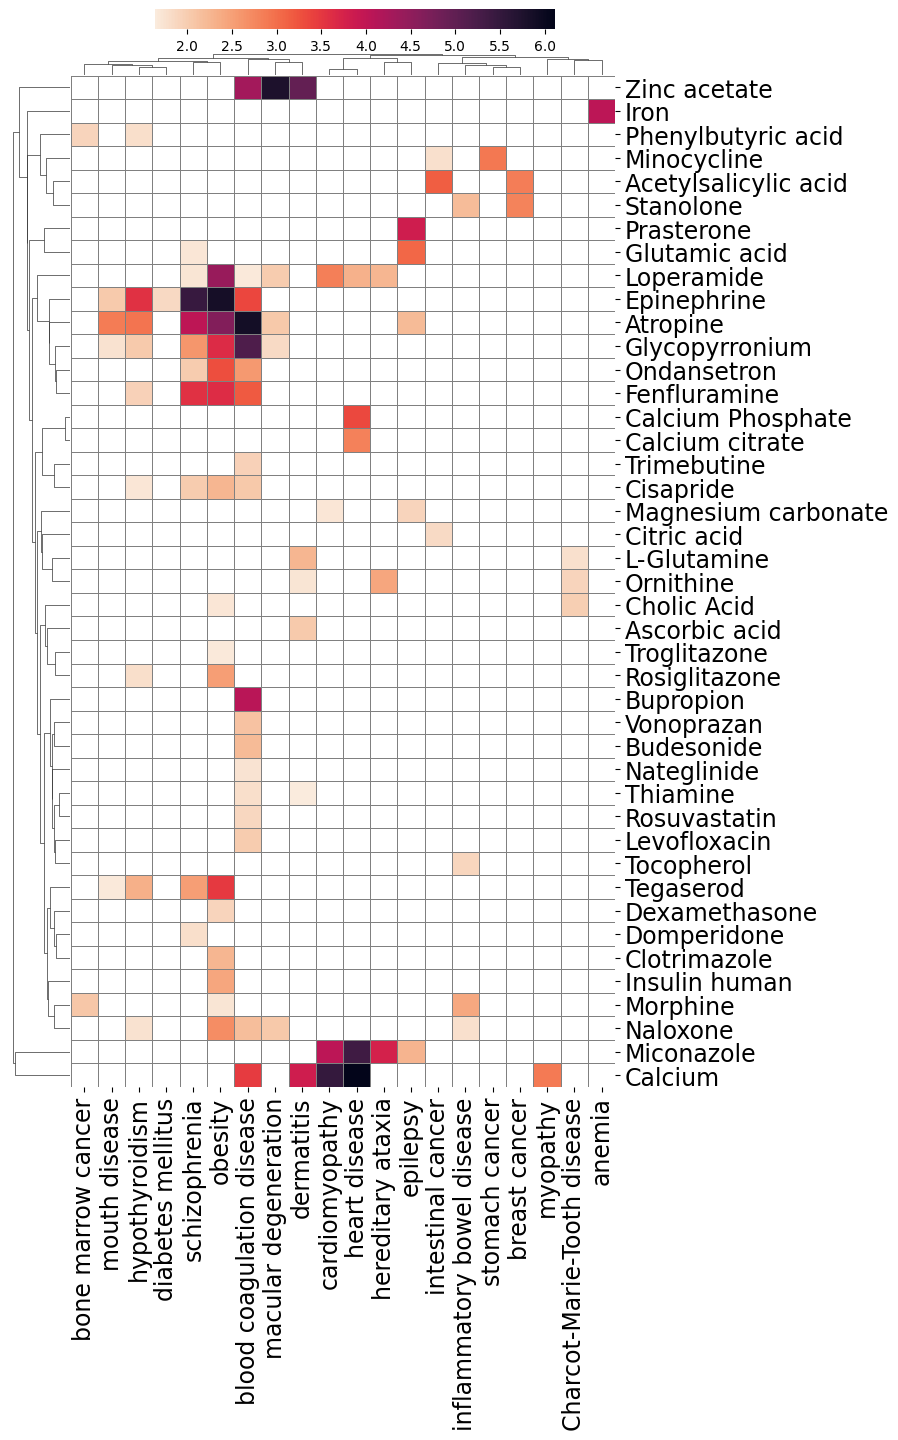

SENSORY ORGANS


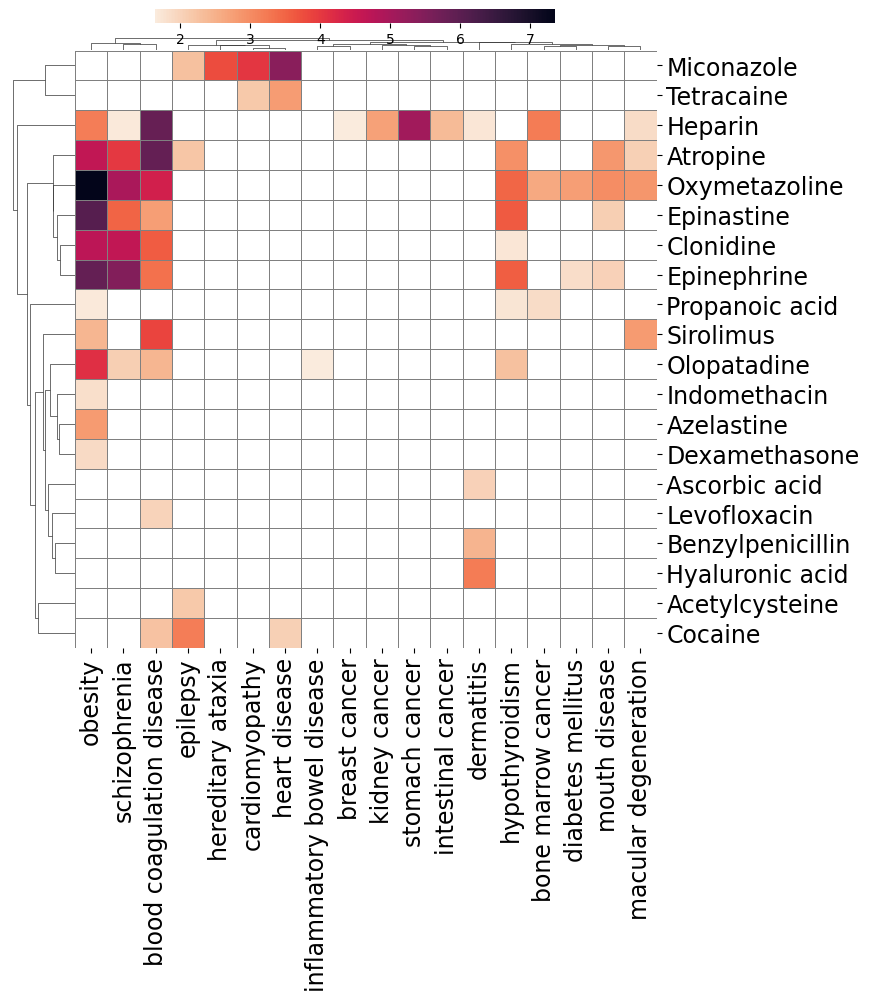

VARIOUS


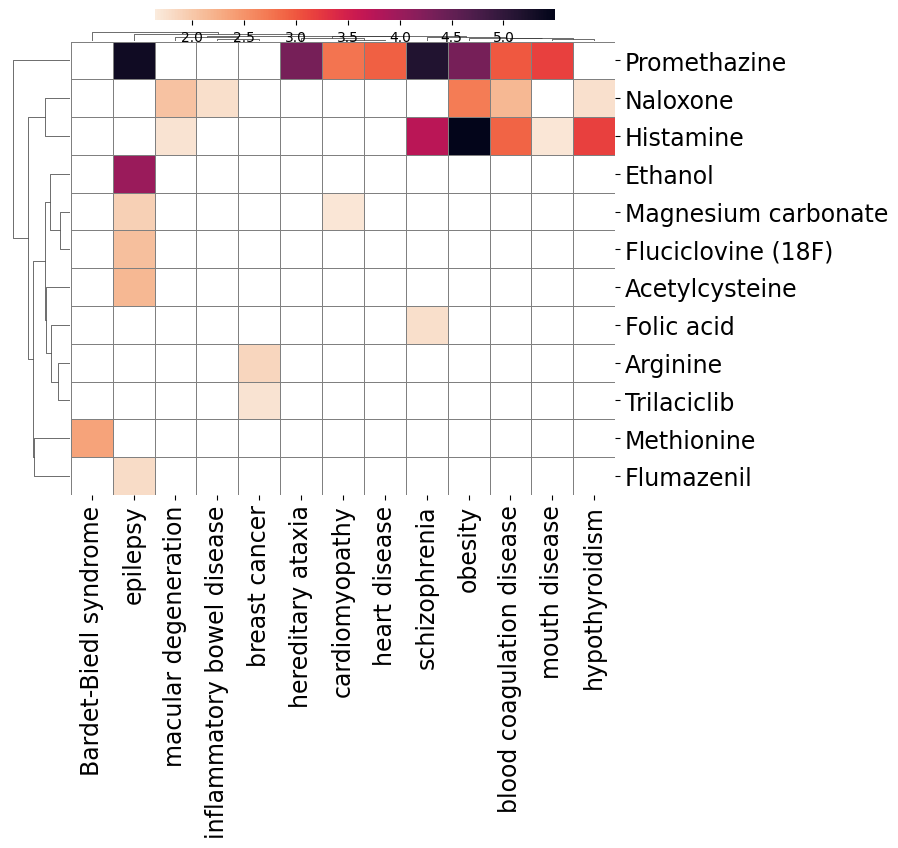

GENITO URINARY SYSTEM AND SEX HORMONES


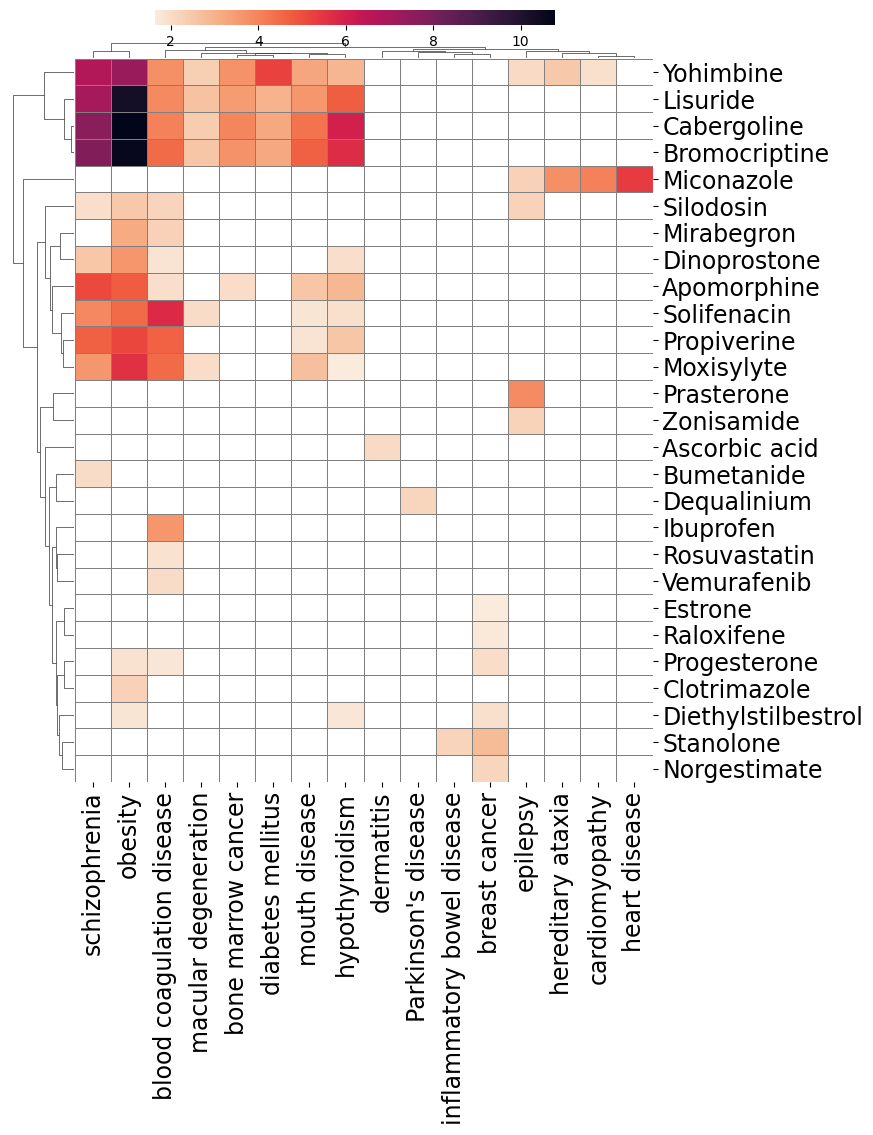

RESPIRATORY SYSTEM


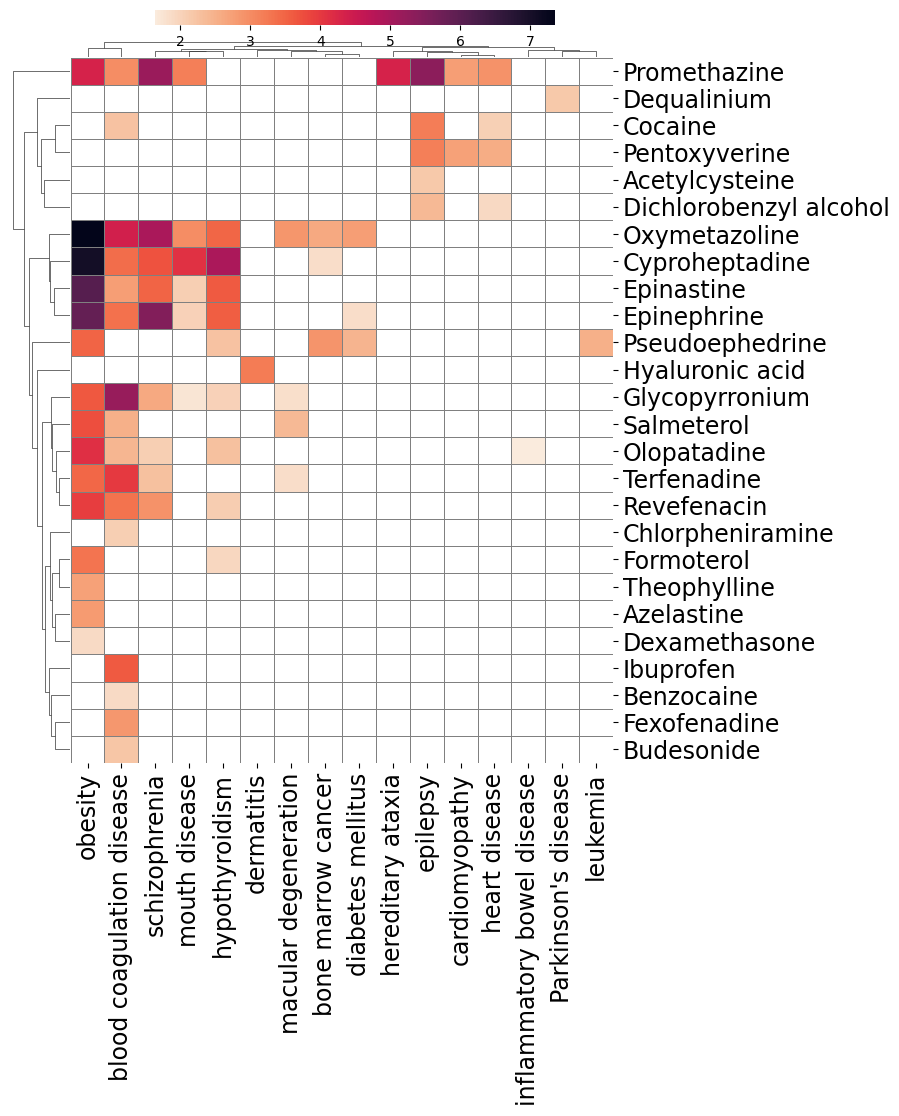

DERMATOLOGICALS


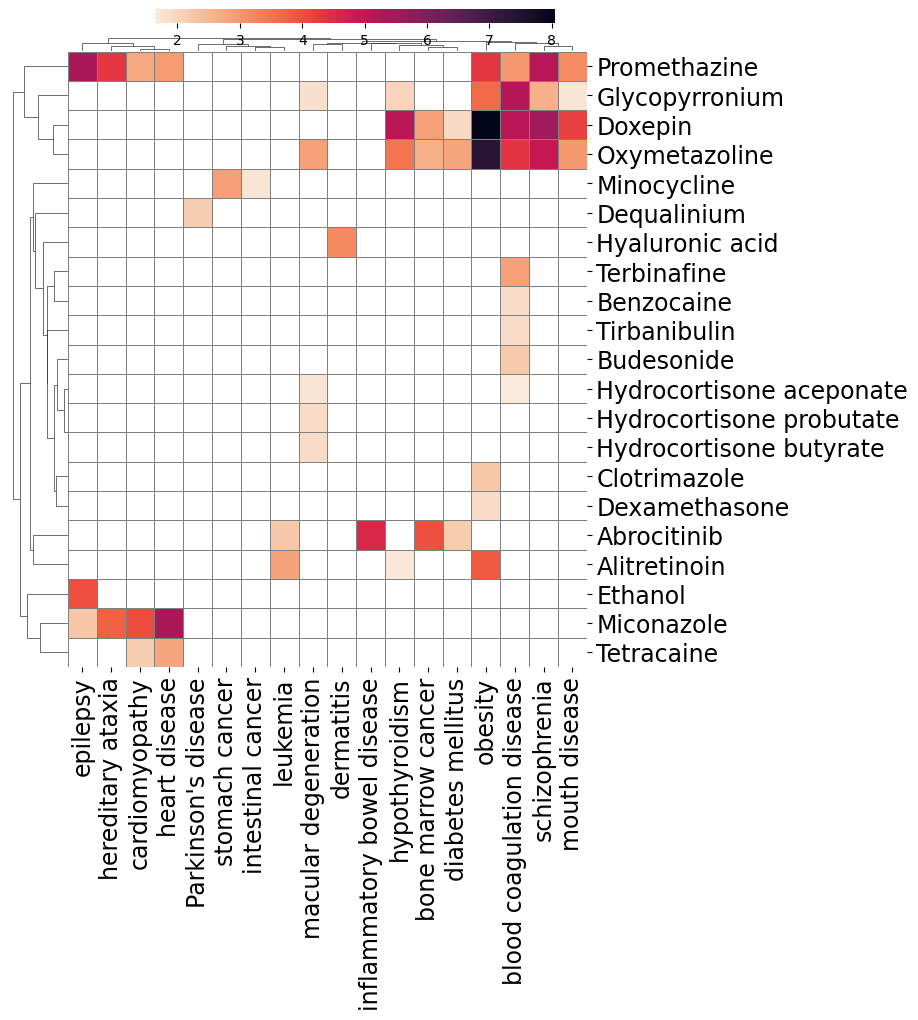

CARDIOVASCULAR SYSTEM


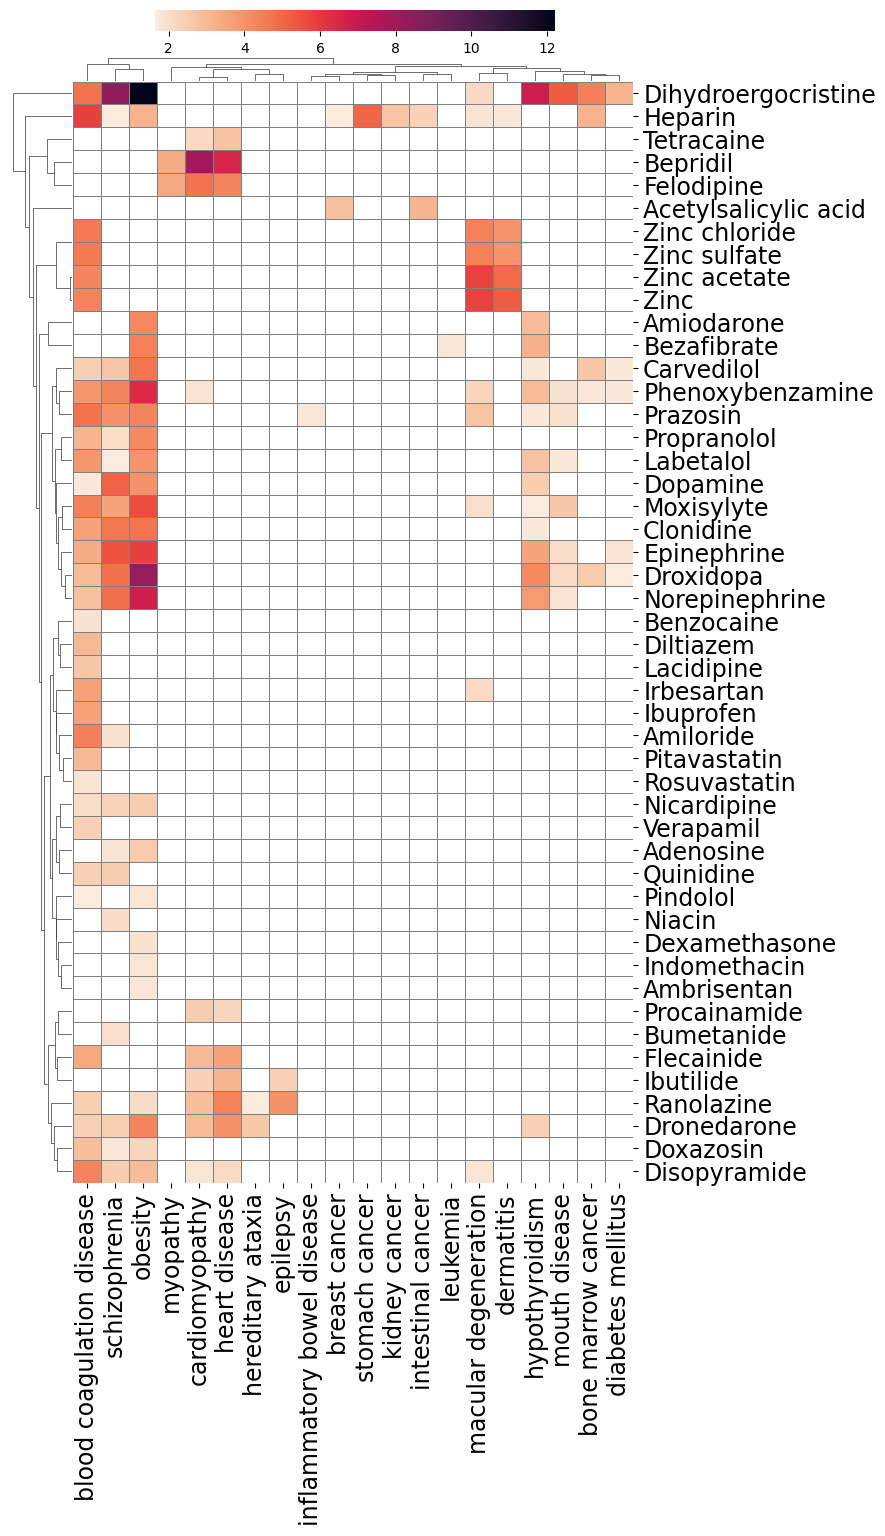

NERVOUS SYSTEM


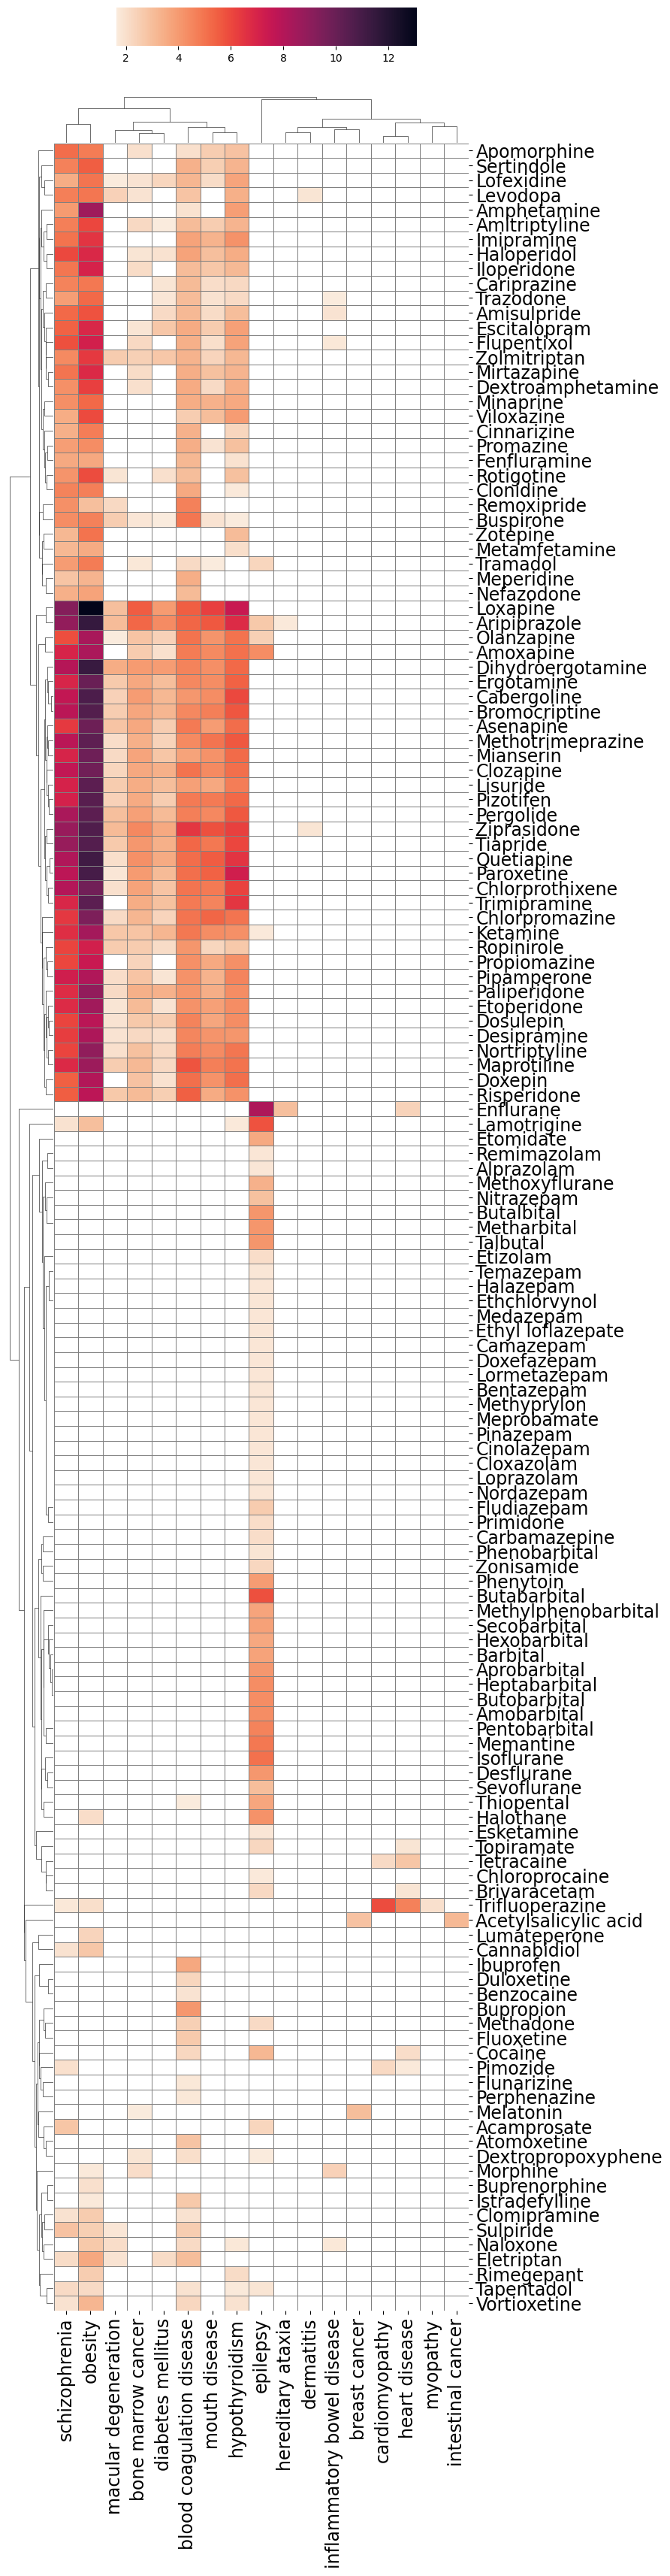

ANTIINFECTIVES FOR SYSTEMIC USE


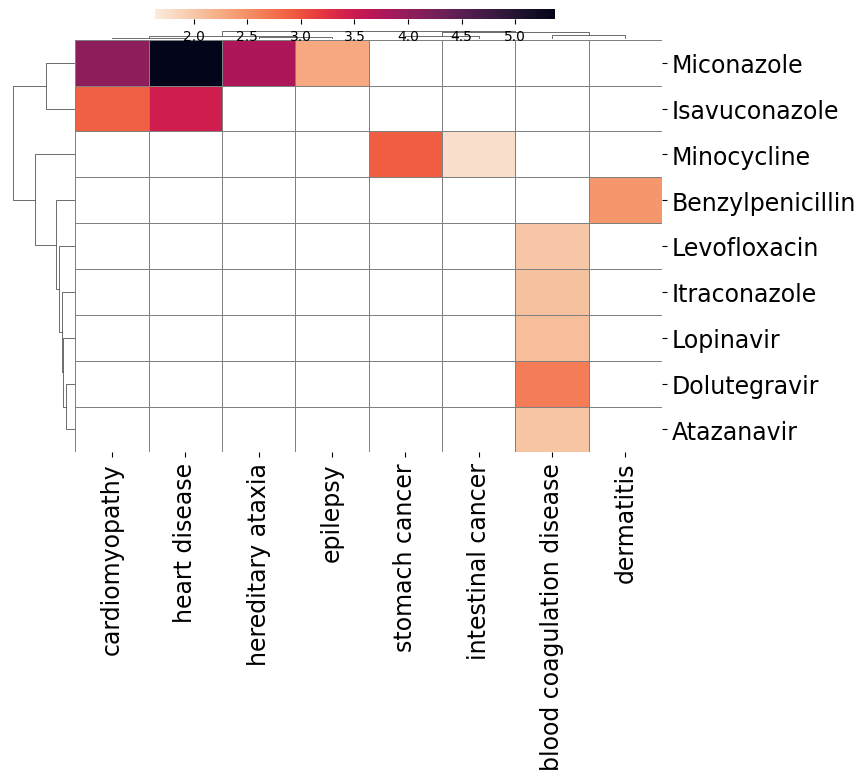

MUSCULO-SKELETAL SYSTEM


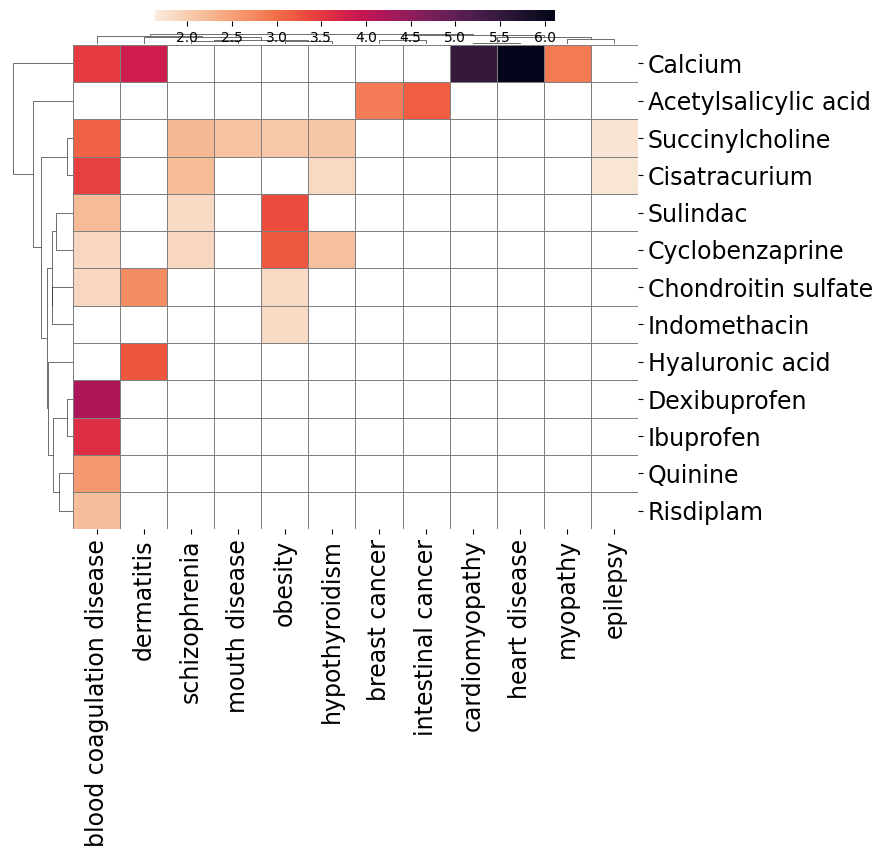

SYSTEMIC HORMONAL PREPARATIONS, EXCL. SEX HORMONES AND INSULINS


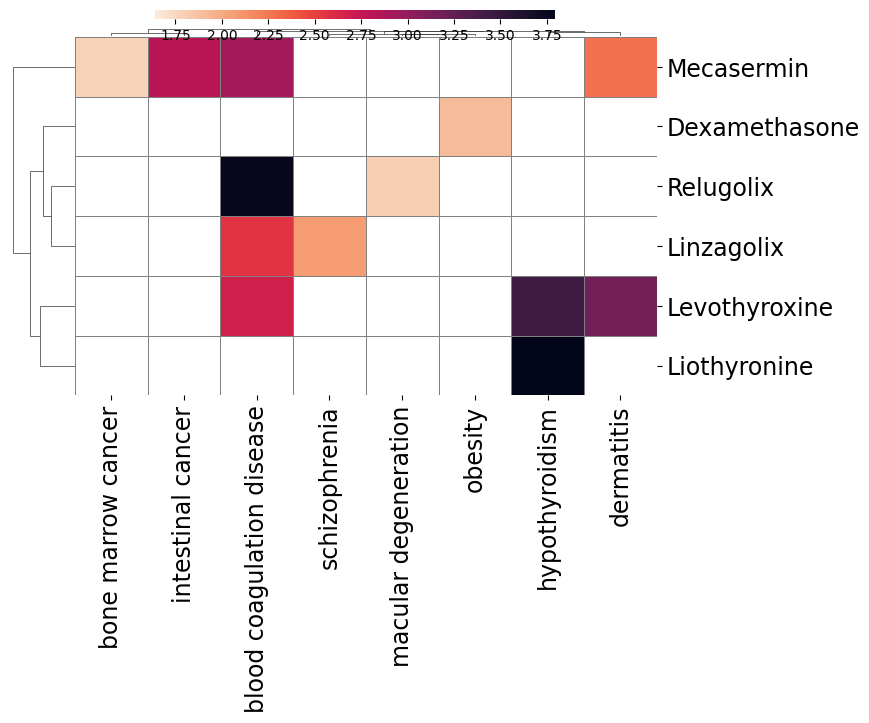

ANTIPARASITIC PRODUCTS, INSECTICIDES AND REPELLENTS


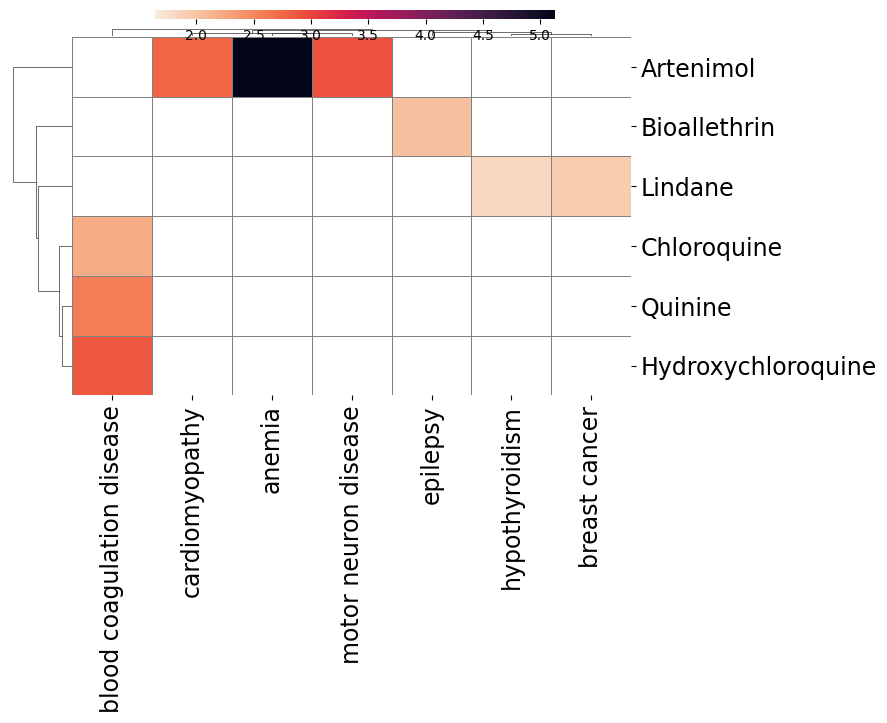

In [13]:
for x in atcs2terms.keys():
    print(atc2name[x])
    terms = list(atcs2terms[x])
    sub_matrix = result.loc[terms][omim_slim_terms]
    sub_matrix = sub_matrix.loc[:,((sub_matrix>1.64).sum(axis=0) != 0)]
    sub_matrix = sub_matrix.loc[((sub_matrix>1.64).sum(axis=1) != 0)]
    a_fig=sns.clustermap(sub_matrix.values, 
                yticklabels=[drug_term2name[x].split(',')[0] for x in sub_matrix.index], 
                xticklabels=[omim_term2name[x] for x in sub_matrix.columns], 
                   figsize=(8, 5+sub_matrix.shape[0]/5), 
                         dendrogram_ratio=0.1, cbar_pos=(0.2, 0.94, .5, .015),
                linewidths=0.5, linecolor='grey', mask=1-(sub_matrix.values>1.64),
               vmin=1.64, cmap='rocket_r',cbar_kws={"orientation": "horizontal"})
    a_fig.ax_heatmap.set_xticklabels(a_fig.ax_heatmap.get_xmajorticklabels(), fontsize = 17)
    a_fig.ax_heatmap.set_yticklabels(a_fig.ax_heatmap.get_ymajorticklabels(), fontsize = 17)
    col = a_fig.ax_col_dendrogram.get_position()
    a_fig.ax_col_dendrogram.set_position([col.x0, col.y0, col.width, col.height*0.2])
    plt.show()
